## <a id='toc1_1_1_'></a>[*** OUTDATED ***](#toc0_)
### <a id='toc1_1_1_'></a>[OpenVINO XAI getting started](#toc0_)

**OpenVINO™ Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

It depicts a heatmap with areas of interest for neural network (classification or detection) where it focuses before making a desicion.

Example: Saliency map for `person` class for EfficientV2 classification model:


![Saliency map for "person" class for classification model](docs/images/saliency_map_person.png)

**Table of contents**<a id='toc0_'></a>    
- [OpenVINO XAI getting started](#toc1_1_1_)    
    - [Installation](#toc1_1_2_)    
    - [Preparation](#toc1_1_3_)    
    - [Model preparation](#toc1_1_4_)    
    - [Auto-Explainer algorithm](#toc1_1_5_)    
      - [Predictions sanity check](#toc1_1_5_1_)    
    - [White Box](#toc1_1_6_)    
      - [Explain Parameters](#toc1_1_6_1_)    
    - [Post Proccessor](#toc1_1_7_)    
    - [TargetExplainGroup](#toc1_1_8_)    
    - [Black Box algorithm](#toc1_1_9_)    
      - [Black Box Parametrization](#toc1_1_9_1_)    
    - [Advanced](#toc1_1_10_)    
      - [Insert XAI branch into IR](#toc1_1_10_1_)    
      - [Explaining timm models](#toc1_1_10_2_)    
      - [More documentation](#toc1_1_10_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_2_'></a>[Installation](#toc0_)

In [ ]:
# Create virtual env
!python3 -m venv .ovxai

# Activate virtual env
!source .ovxai/bin/activate

# Package installation
%pip install .

### <a id='toc1_1_3_'></a>[Preparation](#toc0_)

In [ ]:
%pip install matplotlib

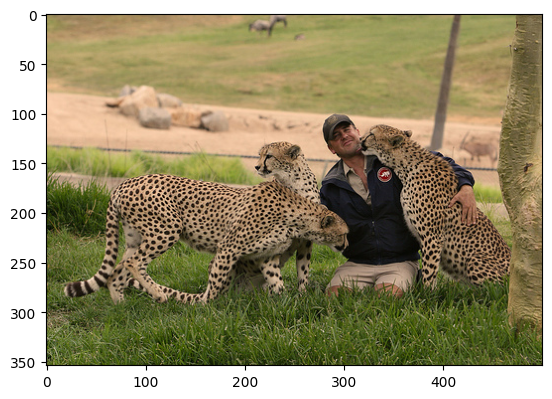

In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# get the image
image_path = "./tests/assets/cheetah_person.jpg"
image = cv2.imread(image_path)
image_name = Path(image_path).stem

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### <a id='toc1_1_4_'></a>[Model preparation](#toc0_)

In [2]:
# Model retrieval
from openvino_xai.utils import retrieve_otx_model

retrieve_otx_model(".", # Destination folder
                   "mobilenetv3_large_100.ra_in1k", # Model name
                   dir_url="https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification")

# Please manually check the size of the downloaded model to be more than 2 KB
model_path = "./otx_models/mobilenetv3_large_100.ra_in1k.xml"

You can run the explanation for your own models. To do that, download `IR (.bin + .xml)` model using `wget` or `urlretrieve` and pass the path as `model_path`. To run explanation on timm models refer to [Explaining timm models](#toc1_1_10_2_) section.

For BlackBox Explainer `ONNX (.onnx)` model can be passed as well.

In [3]:
from openvino_xai.utils import logger

### <a id='toc1_1_5_'></a>[Auto-Explainer algorithm](#toc0_)
Auto-Explainer algorithm is the easiest way to get the saliency map from model, if you're not sure which method to use.

If possible, the algorithm will run the `White Box explainer` method. White Box explainer adds an extra XAI branch into the IR graph which generates explain result during model inference.

If White Box method can't be applied for some reason, the `Black Box explainer` is used. It treats model as a black-box, so it works regardless of the model type. But the explanation process relies on the huge amount of input perturbation and repetitive inferences, so it takes much more time then the `White Box` method.

INFO:openvino_xai:Model does not have XAI - trying to insert XAI and use White Box explainer.
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:Auto example: generated 1 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_GRAY with shape (7, 7).


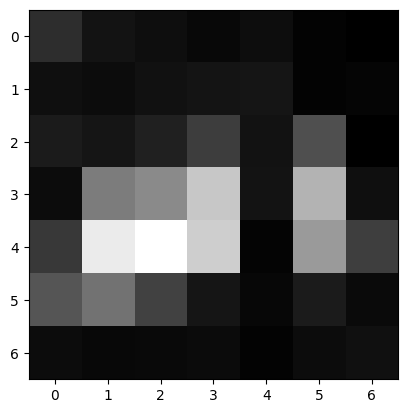

In [4]:
from openvino.model_api.models import ClassificationModel
from openvino_xai.explain import ClassificationAutoExplainer

# Create an OpenVINO™ ModelAPI model wrapper for Classification model
model = ClassificationModel.create_model(model_path, model_type="Classification")

# Explainer initialization and explanation
auto_explainer = ClassificationAutoExplainer(model)
# This code returns gray-scale unprocessed saliency map
explanation = auto_explainer.explain(image)
logger.info(f"Auto example: generated {len(explanation.map)} classification "
            f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}.")

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/auto_explain/wo_postrocessing"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
# This code returns gray-scale unprocessed saliency map
plt.imshow(image_sal_map)
plt.show()


That code returns unprocessed results, small and grayscale. To know more about postprocessing, refer to [Post Proccessor](#toc1_1_6_) chapter.

#### <a id='toc1_1_5_1_'></a>[Predictions sanity check](#toc0_)

You can make sure that the model worked correctly by checking the predicted classes and it's confidence. To return the list of predicted classes, see `explanation.predictions`.

In [5]:
explanation.predictions

[(293, 'cheetah', 0.97950923)]

### <a id='toc1_1_6_'></a>[White Box](#toc0_)

If possible, the `AutoExplain` algorithm will try to run the `White Box` explain method first. But it is possible to run `White Box Explainer` directly.

It treats model as a white box and needs to make inner modifications. It adds extra XAI nodes after backbone to estimate which activations are important for model prediction.

It works fast and precisely and requires only one model inference.

INFO:openvino_xai:Created Model API wrapper.
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:White-Box example w/o explain_parameters: generated 1 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_GRAY with shape (7, 7).


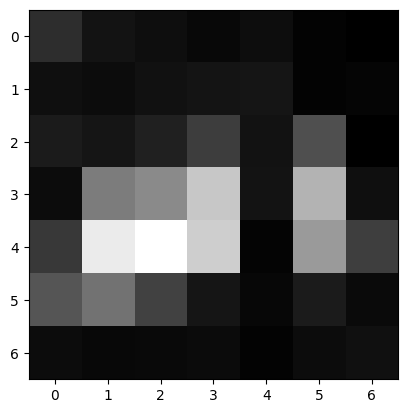

In [6]:
from openvino_xai.explain import WhiteBoxExplainer
from openvino_xai.model import XAIClassificationModel

# Create an OpenVINO™ ModelAPI model wrapper with XAI head inserted into the model graph
model = XAIClassificationModel.create_model(model_path, model_type="Classification")

# Explainer initialization and explanation
explainer = WhiteBoxExplainer(model)
# This code returns gray-scale unprocessed saliency map
# By default it returns one saliency map for each predicted class
explanation = explainer.explain(image)
logger.info(
    f"White-Box example w/o explain_parameters: generated {len(explanation.map)} classification "
    f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}."
)

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/white_explain/wo_postrocessing"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

#### <a id='toc1_1_6_1_'></a>[Explain Parameters](#toc0_)

`White Box explainer` can be configured with the following parameters:
- `target_layer` - specifies the layer after which the XAI nodes should be inserted (the last convolutional layer is a good default option). Example: `/backbone/conv/conv.2/Div`. This parameter can be useful if `WhiteBoxExplainer` fails to find a place where to insert XAI branch.
-  `embed_normalization` - **default True** (for speed purposes), but you can disable embedding of normalization into the model.
- `explain_method_type` - **default reciprocam**:

    For Classification models `White Box` algorithm supports 2 `XAIMethodType`:
    - activationmap - returns a single saliency map regardless of the classes
    - reciprocam - returns saliency maps for each class the model can detect

    For Detection model it supports:
    - detclassprobabilitymap - returns saliency maps for each class

INFO:openvino_xai:Created Model API wrapper.
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:White-Box example w/ explain_parameters: generated 1 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_GRAY with shape (7, 7).


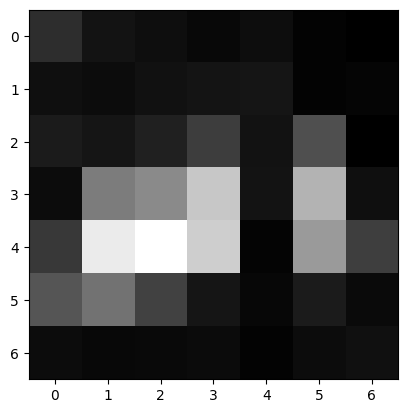

In [7]:
from openvino_xai.model import XAIClassificationModel
from openvino_xai.parameters import ClassificationExplainParametersWB, XAIMethodType

# Parametrize White Box Explainer
explain_parameters = ClassificationExplainParametersWB(
    # target_layer="/backbone/conv/conv.2/Div",  # OTX mobilenet_v3
    # target_layer="/backbone/features/final_block/activate/Mul",  # OTX efficientnet
    explain_method_type=XAIMethodType.RECIPROCAM,
)

# Create an OpenVINO™ ModelAPI model wrapper for Classification model
model = XAIClassificationModel.create_model(
    model_path, model_type="Classification", explain_parameters=explain_parameters,
)

# Explainer initialization and explanation
explainer = WhiteBoxExplainer(model)
# This code returns gray-scale unprocessed saliency map
explanation = explainer.explain(image)
logger.info(
    f"White-Box example w/ explain_parameters: generated {len(explanation.map)} classification "
    f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}."
)

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/white_explain/w_explain_parameters"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

### <a id='toc1_1_7_'></a>[Post Proccessor](#toc0_)

In every example above, returned saliency maps are in raw: small and grayscale. To apply postprocessing, you can use the following `PostProcessParameters`:

- normalize - **default False**, normalize saliency map into [0, 255] range (filling the whole range) and convert to `uint8` data type. Disabled by default, it is assumed that normalization should be inserted into the IR graph and therefore will be performed during the model inference (required for speed).
- resize - **default False**, resize saliency map to the input image size.
- colormap - **default False**, apply colormap to the grayscale saliency map.
- overlay - **default False**, generate overlay of the saliency map over the input image.

INFO:openvino_xai:Created Model API wrapper.
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:White-Box example w/ postprocessing: generated 1 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_COLOR with shape (354, 500, 3).


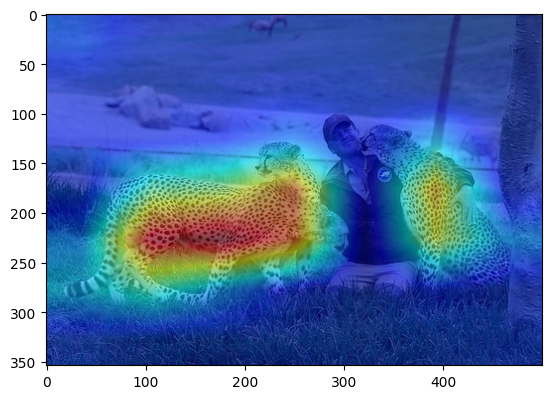

In [8]:
from openvino_xai.explain import WhiteBoxExplainer
from openvino_xai.model import XAIClassificationModel
from openvino_xai.parameters import PostProcessParameters
from openvino_xai.saliency_map import TargetExplainGroup

# Pass postprocessing parameters
post_processing_parameters = PostProcessParameters(overlay=True)

# Create an OpenVINO™ ModelAPI model wrapper with XAI head inserted into the model graph
model = XAIClassificationModel.create_model(model_path, model_type="Classification")

# Explainer initialization and explanation
# This code returns colored saliency map after processing
explainer = WhiteBoxExplainer(model)
explanation = explainer.explain(image, 
                                TargetExplainGroup.PREDICTED_CLASSES, # default option, can be ommited
                                post_processing_parameters=post_processing_parameters
                                )
logger.info(
    f"White-Box example w/ postprocessing: generated {len(explanation.map)} classification "
    f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}."
)

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/white_explain/w_postrocessing"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

### <a id='toc1_1_8_'></a>[TargetExplainGroup](#toc0_)
There is a way to parametrize the output saliency maps to return the certain classes (if Explainer returns a separate saliency map for each class). To do that pass to `explain` function the `TargetExplainGroup` parameter with one of these values:
- `ALL_CLASSES` - to return saliency map for each class that model can detect.
- `PREDICTED_CLASSES` - **default**, to return saliency map only for classes that were detected by the model.
- `CUSTOM_CLASSES` - to return saliency maps for specific classes named by index.


INFO:openvino_xai:Created Model API wrapper.
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:White-Box example w/ all_classes: generated 1000 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_GRAY with shape (7, 7).


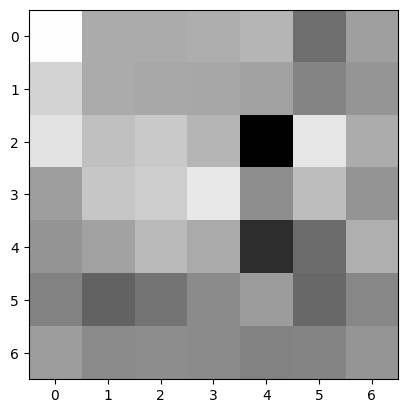

In [9]:
from openvino_xai.explain import WhiteBoxExplainer
from openvino_xai.model import XAIClassificationModel
from openvino_xai.saliency_map import TargetExplainGroup

# Pass postprocessing parameters
post_processing_parameters = PostProcessParameters(overlay=True)

# Create an OpenVINO™ ModelAPI model wrapper with XAI head inserted into the model graph
model = XAIClassificationModel.create_model(model_path, model_type="Classification")

# Explainer initialization and explanation
# This code returns gray-scale unprocessed saliency map
explainer = WhiteBoxExplainer(model)
explanation = explainer.explain(image,
                                TargetExplainGroup.ALL_CLASSES)
# CUSTOM_CLASSES case
# explanation = explainer.explain(image, 
#                                 TargetExplainGroup.CUSTOM_CLASSES, 
#                                 [0,1] # indexes of classes to return saliency maps for
#                                 )
# PREDICTED_CLASSES case
# explanation = explainer.explain(image, 
#                                 TargetExplainGroup.PREDICTED_CLASSES)
logger.info(
    f"White-Box example w/ all_classes: generated {len(explanation.map)} classification "
    f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}."
)

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/white_explain/all_classes"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_jeep.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

As we can see, for a `jeep` class the regions of interest are completely different from `cheetah` class, that looks all other the image except the spot there the person is supposed to be.

### <a id='toc1_1_9_'></a>[Black Box algorithm](#toc0_)

This algorithm treats the model as a black box without altering its structure. So, this method will work on any model that can be inferred and return the class probabilities as output.

The [RISE](https://arxiv.org/pdf/1806.07421.pdf) algorith used for BlackBox applies random masks to hide parts of the image, gets result class probabilities and by that calculates the "importance" of each part of the image for final results. After a few thousands of inferences the summarized saliency map is generated.

Although it's convenient to predict every model as a black-box, this explain algorithm might require many inferences (5000 by default) to generate high quality saliency map.

To parametrize the Black Box explainer, pass the following parameters:
- num_masks - **default 5000**, number of generated masks to aggregate
- num_cells - **default 8**, number of cells for low-dimensional RISE random mask that later will be up-scaled to the model input size

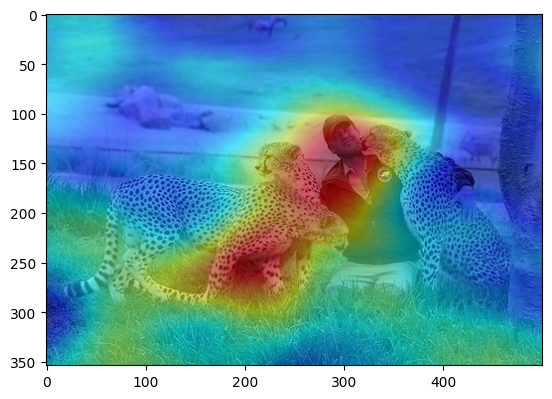

In [12]:
from openvino.model_api.models import ClassificationModel
from openvino_xai.parameters import PostProcessParameters
from openvino_xai.explain import RISEExplainer

# Create an OpenVINO™ ModelAPI model wrapper for Classification model
model = ClassificationModel.create_model(
    model_path, model_type="Classification", 
    # It's important to pass output_raw_scores for Black Box Explainer
    configuration={"output_raw_scores": True}
)

# Pass postprocessing parameters
post_processing_parameters = PostProcessParameters(overlay=True)

# Explainer initialization and explanation
explainer = RISEExplainer(model)
# This code returns colored saliency map after processing
explanation = explainer.explain(image, post_processing_parameters=post_processing_parameters)
logger.info(
    f"Black-Box example w/ post_processing_parameters: generated {len(explanation.map)} "
    f"classification saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}."
)

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/black_box/w_postprocessing"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

#### <a id='toc1_1_9_1_'></a>[Black Box Parametrization](#toc0_)

Varying `num_cells`/`num_masks` parameters can achieve different goals:
- To speed up the explanation, we can reduce the number of `num_mask`. But the result saliency maps will decrease the quality, so this optil can be used for big and focused objects.
- The more `num_cells` we have, the more fine-grained result we can expect. Bit big `num_cells` requires bigger `num_masks` to converge. This would work better work for classes with complex shape. See examples below. 

In [102]:
explainer = RISEExplainer(model, num_cells=4, num_masks=1000)
explanation = explainer.explain(image, post_processing_parameters=post_processing_parameters)
explanation.save("saliency_map/black_box/4_cells_1000_masks", image_name)

explainer = RISEExplainer(model, num_cells=8, num_masks=5000)
explanation = explainer.explain(image, post_processing_parameters=post_processing_parameters)
explanation.save("saliency_map/black_box/8_cells_5000_masks", image_name)

explainer = RISEExplainer(model, num_cells=16, num_masks=10000)
explanation = explainer.explain(image, post_processing_parameters=post_processing_parameters)
explanation.save("saliency_map/black_box/16_cells_10000_masks", image_name)

explainer = RISEExplainer(model, num_cells=24, num_masks=15000)
explanation = explainer.explain(image, post_processing_parameters=post_processing_parameters)
explanation.save("saliency_map/black_box/24_cells_15000_masks", image_name)

INFO:openvino_xai:RISEExplainer explains the model in asynchronous mode with 15000 masks (inference calls)...


In [13]:
sal_maps = [None] * 4

sal_map = cv2.imread(f"saliency_map/black_box/4_cells_1000_masks/cheetah_person_target_cheetah.jpg")
sal_maps[0] = cv2.cvtColor(sal_map, cv2.COLOR_BGR2RGB)

sal_map = cv2.imread(f"saliency_map/black_box/8_cells_5000_masks/cheetah_person_target_cheetah.jpg")
sal_maps[1] = cv2.cvtColor(sal_map, cv2.COLOR_BGR2RGB)

sal_map = cv2.imread(f"saliency_map/black_box/16_cells_10000_masks/cheetah_person_target_cheetah.jpg")
sal_maps[2] = cv2.cvtColor(sal_map, cv2.COLOR_BGR2RGB)

sal_map = cv2.imread(f"saliency_map/black_box/24_cells_15000_masks/cheetah_person_target_cheetah.jpg")
sal_maps[3] = cv2.cvtColor(sal_map, cv2.COLOR_BGR2RGB)

<Figure size 640x480 with 0 Axes>

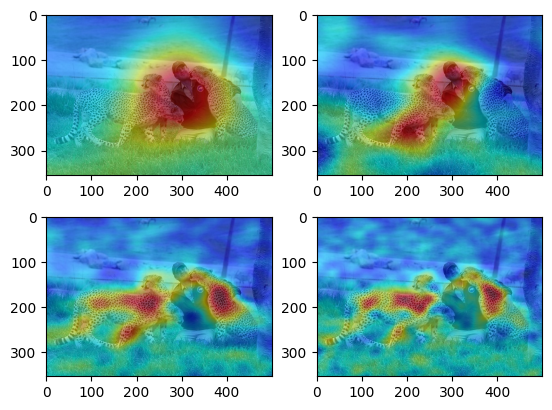

In [14]:
plt.figure()

f, axarr = plt.subplots(2,2) 
axarr[0, 0].imshow(sal_maps[0])
axarr[0, 1].imshow(sal_maps[1])
axarr[1, 0].imshow(sal_maps[2])
axarr[1, 1].imshow(sal_maps[3])
plt.show()

### <a id='toc1_1_10_'></a>[Advanced](#toc0_)

#### <a id='toc1_1_10_1_'></a>[Insert XAI branch into IR](#toc0_)

You can add XAI branch and save the updated IR model, so `saliency_map` will be one of the model's outputs along with regular model outputs.
Such updated model can be used in your own inference pipeline to get explanation saliency maps.

No inference is needed for that.

In [ ]:
"""Embedding XAI into the model graph and save updated IR, no actual inference performed.
User suppose to use his/her own inference pipeline to get explanations along with the regular model outputs."""

output = "ir_model_update_wo_inference"
model_with_xai = XAIClassificationModel.insert_xai_into_native_ir(model_path, output)
logger.info(f"Model with XAI head saved to {output}")

#### <a id='toc1_1_10_2_'></a>[Explaining timm models](#toc0_)

Download your timm IR and pass the path as a `model_path`. Here is an example using the previous model.

In [11]:
# Model retrieval
from openvino_xai.utils import retrieve_otx_model

retrieve_otx_model(".", # Destination folder
                   "mobilenetv3_large_100.ra_in1k", # Model name
                   dir_url="https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification")
# Please manually check the size of the downloaded model to be more than 2 KB
model_path = "./otx_models/mobilenetv3_large_100.ra_in1k.xml"

See more examples of retrieving timm models in [tests/test_classification_timm.py](tests/test_classification_timm.py)

In [15]:
# Adding extra model parameters
mapi_params = {
    "configuration": {
        # Update or remove mean and scale values according to your model 
        "mean_values": [123.675, 116.28, 103.53],
        "scale_values": [58.395, 57.12, 57.375],
        "output_raw_scores": True,
    }
}

In [16]:
from openvino.model_api.models import ClassificationModel

# Create an OpenVINO™ ModelAPI model wrapper for Classification model
model = ClassificationModel.create_model(model_path, model_type="Classification", **mapi_params)

In [17]:
from openvino_xai.explain import ClassificationAutoExplainer

# Explainer initialization and explanation
auto_explainer = ClassificationAutoExplainer(model)
post_processing_parameters = PostProcessParameters(overlay=True)

# This code returns gray-scale unprocessed saliency map
explanation = auto_explainer.explain(image, post_processing_parameters=post_processing_parameters)
logger.info(f"Auto example: generated {len(explanation.map)} classification "
            f"saliency maps of layout {explanation.layout} with shape {explanation.sal_map_shape}.")

# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/timm_model"
explanation.save(output_dir, image_name)

INFO:openvino_xai:Model does not have XAI - trying to insert XAI and use White Box explainer.


INFO:openvino_xai:Insertion of the XAI branch into the model was successful.
INFO:openvino_xai:Auto example: generated 1 classification saliency maps of layout SaliencyMapLayout.MULTIPLE_MAPS_PER_IMAGE_COLOR with shape (354, 500, 3).


 This model doesn't have the list of labels as model attribute, so saved saliency map doesn't have the label name in name. Instead of it the saliency map name has the label index. To know the name of predicted label, use the index and [ImageNet labels list](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

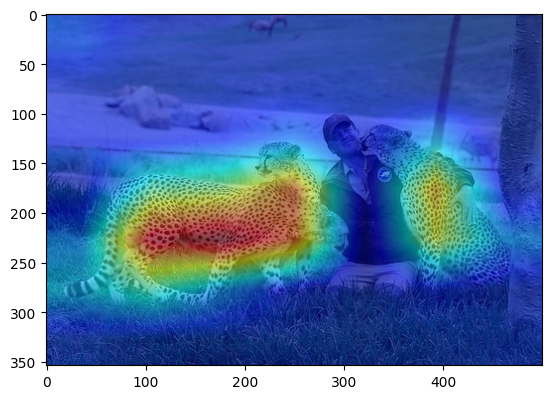

In [19]:
# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_cheetah.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

#### <a id='toc1_1_10_3_'></a>[More documentation](#toc0_)

For more examples refer to [run_classification.py](examples/run_classification.py) and [run_detection.py](examples/run_detection.py)

API documentation can be found [here](https://curly-couscous-ovjvm29.pages.github.io/).